In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [29]:
id=[]
station=[]
date=[]
prcp=[]
tobs=[]
data=[]
for row in session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).all():
    id.append(row[0])
    station.append(row[1])
    date.append(row[2])
    prcp.append(row[3])
    tobs.append(row[4]) 

In [9]:
# test the table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [30]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

2016-08-23


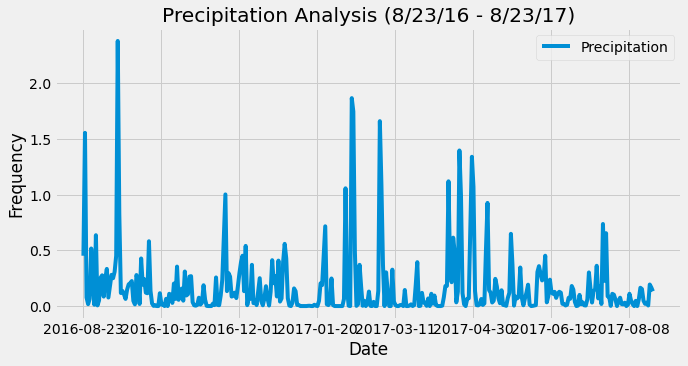

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

end_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(end_date) 

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, func.avg(measurement.prcp)).\
    filter(measurement.date >= end_date).\
    group_by(measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precip_data)
precipitation_df[['Date','Precipitation']] = precipitation_df[[0,1]]
precipitation_df = precipitation_df[['Date','Precipitation']].set_index('Date')

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

ax = precipitation_df.plot(figsize=(10,5))
ax.set_title("Precipitation Analysis (8/23/16 - 8/23/17)")
ax.set_ylabel("Frequency")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number stations in the dataset
locations = session.query(measurement).group_by(measurement.station).count()
locations

9

In [55]:
# # Design a query to find the most active stations (i.e. what stations have the most rows?)
# # List the stations and the counts in descending order.
active_stations = session.query(measurement.station, 
                func.count(measurement.station).label('count DESC')).\
                group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(measurement.station,
                            func.count(measurement.station).\
                            label('count DESC')).\
                            group_by(measurement.station).\
                            order_by(func.count(measurement.station).desc()).limit(1)[0][0]
most_active

best_station = active_stations[0][0]
session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
                filter(measurement.station == best_station).all() 

[(54.0, 71.66378066378067, 85.0)]

In [65]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = [func.min(measurement.tobs),
                func.max(measurement.tobs),
                func.avg(measurement.tobs)]

tobs = session.query(measurement.tobs).\
    filter(measurement.station==most_active).\
    filter(measurement.date > end_date).\
    order_by(measurement.date.desc()).all()

tobs_df = pd.DataFrame(tobs)

tobs_df = tobs_df.rename(columns={0:'tobs'})
tobs_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


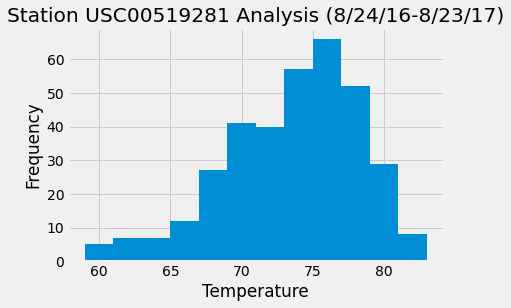

In [67]:
# histogram plot

plt.hist(tobs_df['tobs'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Station " + most_active + " Analysis (8/24/16-8/23/17)")
plt.show()

# Close session

In [68]:
# Close Session
session.close()